In [7]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [8]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [0.0, 0.0, 0.0] ],
            ["H", [dist, 0.0, 0.0] ]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver
    )

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [9]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 5.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated.")

Interatomic Distance: 0.5 VQE Result: -1.05516 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -1.11629 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -1.13619 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -1.13415 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -1.12056 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -1.10115 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -1.07919 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -1.05674 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -1.03519 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -1.01547 Exact Energy: -1.01547
Interatomic Distance: 1.5 VQE Result: -0.99815 Exact Energy: -0.99815
Interatomic Distance: 1.6 VQE Result: -0.98347 Exact Energy: -0.98347
Interatomic Distance: 1.7 VQE Result: -0.97143 Exact Energy: -0.97143
Interatomic Distance: 1.8 VQE Result: -0.96182 Exact Energy: -0.96182
Interatomic Distance

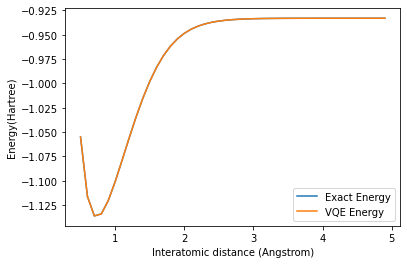

In [10]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Interatomic distance (Angstrom)')
plt.ylabel('Energy(Hartree)')
plt.legend()
plt.show()